## n_iter 500 - RandomizedSearchCV 이용한 DT, RF, GB Model 

In [10]:
# 실행결과 경고메시지 출력 제외
import warnings

warnings.filterwarnings('ignore')

# 데이터 구성:Series, DataFrame
import pandas as pd

# 배열 구성
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

# export_graphviz: 나무 구조 생성 및 저장 
from sklearn.tree import export_graphviz

# graphviz : 나무 구조 시각화  (.dot 확장자 파일 불러오기 등)
import graphviz

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split

# 예측/회귀 Decision Tree
from sklearn.tree import DecisionTreeClassifier

# 예측/회귀 Random Forest
from sklearn.ensemble import RandomForestClassifier

# 예측/회귀 xgboost  
from xgboost import XGBClassifier

# 모델 성능 평가: Precision, Recall, F1 Score, ROC Curve, AUC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score

# Check the Frequency of Variable
from collections import Counter

# Scale 변환:평균,표준편차 기준
from sklearn.preprocessing import StandardScaler

# 변수 중요도 확인: F1 점수 기준
from xgboost import plot_importance

# 샘플링 : Over-sampling 등
from imblearn.over_sampling import SMOTE

# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

# 최적 모델, 파라미터 탐색
from sklearn.model_selection import RandomizedSearchCV

# 맑은 고딕 적용
matplotlib.rc("font", family = "Malgun Gothic")
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)

#### 데이터 불러오기

In [2]:
# 데이터 불러오기
df_raw = pd.read_csv("preprocessed_scale.csv")
df_raw.head()

# Data 구조 확인
print("Data 구조:", df_raw.shape)
print()
print("변수 : ", df_raw.columns)

# 결측치 확인 (각 열별 결측치 개수를 확인)
df_raw.isnull().sum(axis=0)

Data 구조: (994, 15)

변수 :  Index(['scale', 'steel_kind', 'pt_thick', 'pt_width', 'pt_length', 'hsb',
       'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'fur_soak_time',
       'rolling_method', 'rolling_temp', 'descaling_count', 'fur_preheat_time',
       'furnace'],
      dtype='object')


scale               0
steel_kind          0
pt_thick            0
pt_width            0
pt_length           0
hsb                 0
fur_heat_temp       0
fur_heat_time       0
fur_soak_temp       0
fur_soak_time       0
rolling_method      0
rolling_temp        0
descaling_count     0
fur_preheat_time    0
furnace             0
dtype: int64

#### 범주형 설명변수 더미변환

In [3]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,rolling_temp,descaling_count,...,hsb_미적용,hsb_적용,rolling_method_CR(제어압연),rolling_method_TMCP(온도제어),furnace_1호기1열,furnace_1호기2열,furnace_2호기1열,furnace_2호기2열,furnace_3호기1열,furnace_3호기2열
0,0,32,3700,15100,1144,116,1133,59,934,8,...,False,True,False,True,True,False,False,False,False,False
1,0,32,3700,15100,1144,122,1135,53,937,8,...,False,True,False,True,False,True,False,False,False,False
2,0,33,3600,19200,1129,116,1121,55,889,8,...,False,True,False,True,False,False,True,False,False,False
3,0,33,3600,19200,1152,125,1127,68,885,8,...,False,True,False,True,False,False,False,True,False,False
4,0,38,3100,13300,1140,134,1128,48,873,8,...,False,True,False,True,False,False,False,False,True,False


#### 데이터 분리 : 목표변수 vs 설명변수

In [4]:
# 데이터 분리:설명변수, 목표변수 구분
df_raw_x = df_raw_dummy.drop("scale", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["scale"] 

# 데이터 분할 train_test_split(X: 설명변수, Y: 목표변수, test_size = test 데이터 비율)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234) 

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)

분할 전 설명변수 데이터 : (994, 22)
분할 후 설명변수 데이터 :Train (695, 22)   Test (299, 22)


#### 목표빈수 빈도 확인

In [5]:
# 목표변수 빈도 확인
print(df_raw.value_counts(["scale"]),"\n")
print("scale = 1 비율  ", df_raw.value_counts(df_raw["scale"]==1)/len(df_raw))

scale
0        684
1        310
Name: count, dtype: int64 

scale = 1 비율   scale
False    0.688129
True     0.311871
Name: count, dtype: float64


#### Over Sampling

In [6]:
# Over-sampling 설정
sm = SMOTE(sampling_strategy='auto', random_state=1234)

# train데이터를 이용한 Over-sampling
x_resampled, y_resampled = sm.fit_resample(df_train_x,df_train_y)

# 결과 확인
print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {} \n'.format(y_resampled.shape))

print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

# 변수명
v_feature_name = x_resampled.columns

Over-Sampling 전:
 scale
0    473
1    222
Name: count, dtype: int64 

Over-Sampling 후 Train X: (946, 22)
Over-Sampling 후 Train Y: (946,) 

Over-Sampling 후 '1':473
Over-Sampling 후 '0':473


#### 연속형 설명변수 scaling 변환 -> Pass
오버샘플링한 train 데이터와 샘플링 안한 test 데이터 각각 표준화 작업을 번거롭게 거쳐야함.  
DT, RF, XGBoost는 애초에 불필요 하여 Pass

In [22]:
'''
# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = x_resampled.select_dtypes(exclude = "object")

# 변수명 저장
v_feature_names = df_raw_x_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

display("Scale 변환 전:", df_raw_x_num.head())
display("Scale 변환 후:",df_x_scaled.head())'''

'\n# 연속형 변수 선택 : select_dtypes="object" 제외\ndf_raw_x_num = x_resampled.select_dtypes(exclude = "object")\n\n# 변수명 저장\nv_feature_names = df_raw_x_num.columns\n\n# StandardScaler 적용\nscaler = StandardScaler()\ndf_x_scaled = scaler.fit_transform(df_raw_x_num)\ndf_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)\n\ndisplay("Scale 변환 전:", df_raw_x_num.head())\ndisplay("Scale 변환 후:",df_x_scaled.head())'

#### 설명변수 데이터 결합: scale된 연속형 + dummy된 범주형 -> Pass

In [23]:
'''
display("원래 설명변수:", df_raw_x.head(3))

# 원래 연속형(df_raw_x_num) + dummy된 범주형(df_x_dummy)
df_x_raw_dummy = df_raw_x_num.join(df_x_dummy)
display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:",df_x_raw_dummy.head(3))

# scale된 연속형(df_x_scaled)+ dummy된 범주형(df_x_dummy)
df_x_scale_dummy = df_x_scaled.join(df_x_dummy)
display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:",df_x_scale_dummy.head(3))

# scale된 연속형(df_x_scaled) + 원래 범주형(df_raw_x_char)
df_x_scale_raw = df_x_scaled.join(df_raw_x_char)
display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_x_scale_raw.head(3))'''

'\ndisplay("원래 설명변수:", df_raw_x.head(3))\n\n# 원래 연속형(df_raw_x_num) + dummy된 범주형(df_x_dummy)\ndf_x_raw_dummy = df_raw_x_num.join(df_x_dummy)\ndisplay("원래 연속형+ Dummied 범주형...DT/RF/GB 용:",df_x_raw_dummy.head(3))\n\n# scale된 연속형(df_x_scaled)+ dummy된 범주형(df_x_dummy)\ndf_x_scale_dummy = df_x_scaled.join(df_x_dummy)\ndisplay("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:",df_x_scale_dummy.head(3))\n\n# scale된 연속형(df_x_scaled) + 원래 범주형(df_raw_x_char)\ndf_x_scale_raw = df_x_scaled.join(df_raw_x_char)\ndisplay("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_x_scale_raw.head(3))'

#### 데이터 분할:Train vs. Test -> 불필요

In [24]:
'''
# 원래 연속형+ Dummied 범주형...DT/RF/GB 용:df_x_raw_dummy
df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy, df_raw_y
                                    , test_size = 0.3, random_state = 1234)

display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:", df_train_x_rd.head())

# 기계학습용 데이터(Scaled 연속형+ Dummied 범주형) 분할:df_x_scale_dummy 
df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_scale_dummy, df_raw_y
                                    , test_size = 0.3, random_state = 1234)

display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:", df_train_x_sd.head())

# 회귀분석용(표준화 회귀계수) 데이터(Scaled 연속형+ 원래 범주형) 분할:df_x_scale_raw 
df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_scale_raw, df_raw_y
                                    , test_size = 0.3, random_state = 1234)

display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_train_x_reg.head())'''

'\n# 원래 연속형+ Dummied 범주형...DT/RF/GB 용:df_x_raw_dummy\ndf_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy, df_raw_y\n                                    , test_size = 0.3, random_state = 1234)\n\ndisplay("원래 연속형+ Dummied 범주형...DT/RF/GB 용:", df_train_x_rd.head())\n\n# 기계학습용 데이터(Scaled 연속형+ Dummied 범주형) 분할:df_x_scale_dummy \ndf_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_scale_dummy, df_raw_y\n                                    , test_size = 0.3, random_state = 1234)\n\ndisplay("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:", df_train_x_sd.head())\n\n# 회귀분석용(표준화 회귀계수) 데이터(Scaled 연속형+ 원래 범주형) 분할:df_x_scale_raw \ndf_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_scale_raw, df_raw_y\n                                    , test_size = 0.3, random_state = 1234)\n\ndisplay("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_train_x_reg.head())'

### Decesion Tree

In [8]:
# RandomizedSearchCV를 이용한 최적 parameter로 커스텀
estimator = DecisionTreeClassifier()

# 구하고자 하는 parameter와 범위 (분류용 criterion으로 변경)
param_grid = {
    "max_depth": [int(x) for x in range(1, 31)],            # 최대 깊이
    "min_samples_split": [int(x) for x in range(2, 51)],    # 노드를 분할하기 위한 최소 샘플 수
    "min_samples_leaf": [int(x) for x in range(1, 31)]      # 리프 노드가 되기 위한 최소 샘플 수
}

# 설명력이 높은 최적 parameter 찾기
rand_dt = RandomizedSearchCV(estimator,
    param_distributions=param_grid,
    n_iter=500,
    scoring="accuracy",
    n_jobs=-1, 
    random_state=1234
)
rand_dt.fit(x_resampled, y_resampled)

print("best estimator model: \n{}".format(rand_dt.best_estimator_))
print("\nbest parameter: \n{}".format(rand_dt.best_params_))
print("\nbest score: \n{}".format(rand_dt.best_score_.round(3)))


best estimator model: 
DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=9)

best parameter: 
{'min_samples_split': 9, 'min_samples_leaf': 2, 'max_depth': 10}

best score: 
0.993


In [23]:
# 모델 생성
rand_dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=9, random_state=1234)
rand_dt.fit(x_resampled, y_resampled)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=9,
                       random_state=1234)

In [24]:
# 평가
y_pred = rand_dt.predict(df_test_x)

# train 데이터 정확도
print("Test Accuracy: {0:.3f}\n".format(rand_dt.score(x_resampled, y_resampled)))

# test 데이터 정확도
print("Accuracy on test set: {:.3f}\n".format(rand_dt.score(df_test_x, df_test_y)))

print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가 
print(classification_report(df_test_y, y_pred, digits=3))

Test Accuracy: 0.998

Accuracy on test set: 0.993

Test Confusion matrix: 
[[210   1]
 [  1  87]]
              precision    recall  f1-score   support

           0      0.995     0.995     0.995       211
           1      0.989     0.989     0.989        88

    accuracy                          0.993       299
   macro avg      0.992     0.992     0.992       299
weighted avg      0.993     0.993     0.993       299



In [25]:
# 설명변수 중요도
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rand_dt.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,rolling_temp,0.450
13,hsb_적용,0.212
0,pt_thick,0.129
5,fur_soak_temp,0.118
8,descaling_count,0.082
3,fur_heat_temp,0.007
4,fur_heat_time,0.002
2,pt_length,0.001
15,rolling_method_TMCP(온도제어),0.000
20,furnace_3호기1열,0.000


Text(0, 0.5, '설명변수')

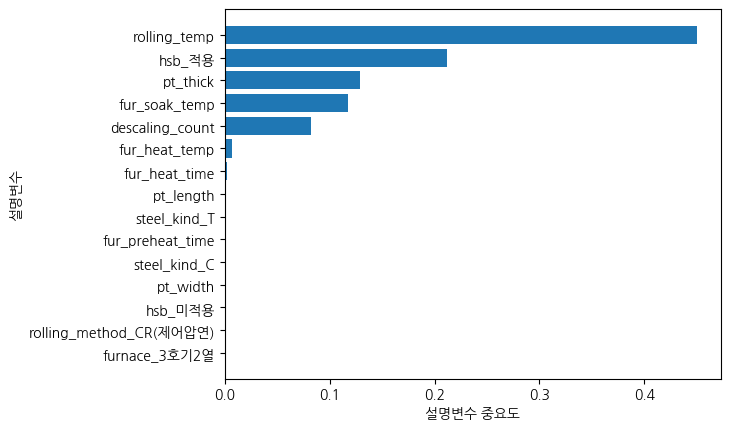

In [27]:
# 설명변수 중요도 그래프
# sort_values : 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))

df_top = df_importance.tail(15)
coordinates = range(len(df_top))
plt.barh(y = coordinates, width = df_top["Importance"])
plt.yticks(coordinates, df_top["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### Random Forest

In [9]:
# RandomForestClassifier 모델 설정
estimator = RandomForestClassifier()

# RandomForestClassifier에 맞는 하이퍼파라미터 범위 설정
param_grid = {
    "n_estimators": [int(x) for x in range(50, 501, 50)],   # 트리 개수
    "max_depth": [int(x) for x in range(1, 31)],            # 최대 깊이
    "min_samples_split": [int(x) for x in range(2, 51)],    # 노드를 분할하기 위한 최소 샘플 수
    "min_samples_leaf": [int(x) for x in range(1, 31)]      # 리프 노드가 되기 위한 최소 샘플 수
}

# RandomizedSearchCV 설정 및 학습
rand_rf = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    n_iter=500,
    scoring="accuracy",   # 분류 문제에 적합한 평가지표
    n_jobs=-1,
    random_state=1234
)

# 오버샘플링된 학습 데이터 사용
rand_rf.fit(x_resampled, y_resampled)

# 최적의 결과 출력
print("Best estimator model: \n{}".format(rand_rf.best_estimator_))
print("\nBest parameter: \n{}".format(rand_rf.best_params_))
print("\nBest score: \n{}".format(rand_rf.best_score_.round(3)))



Best estimator model: 
RandomForestClassifier(max_depth=13, min_samples_split=9, n_estimators=250)

Best parameter: 
{'n_estimators': 250, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_depth': 13}

Best score: 
0.977


In [29]:
# 모델 생성
rand_rf = RandomForestClassifier(max_depth=13, min_samples_split=9, n_estimators=250, random_state=1234)
rand_rf.fit(x_resampled, y_resampled)

RandomForestClassifier(max_depth=13, min_samples_split=9, n_estimators=250,
                       random_state=1234)

In [30]:
# 평가
y_pred = rand_rf.predict(df_test_x)

# train 데이터 정확도
print("Test Accuracy: {0:.3f}\n".format(rand_rf.score(x_resampled, y_resampled)))

# test 데이터 정확도
print("Accuracy on test set: {:.3f}\n".format(rand_rf.score(df_test_x, df_test_y)))

print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가 
print(classification_report(df_test_y, y_pred, digits=3))

Test Accuracy: 0.999

Accuracy on test set: 0.960

Test Confusion matrix: 
[[205   6]
 [  6  82]]
              precision    recall  f1-score   support

           0      0.972     0.972     0.972       211
           1      0.932     0.932     0.932        88

    accuracy                          0.960       299
   macro avg      0.952     0.952     0.952       299
weighted avg      0.960     0.960     0.960       299



In [32]:
# 설명변수 중요도
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rand_rf.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,rolling_temp,0.263
8,descaling_count,0.124
5,fur_soak_temp,0.109
13,hsb_적용,0.107
1,pt_width,0.062
2,pt_length,0.055
3,fur_heat_temp,0.055
0,pt_thick,0.052
11,steel_kind_T,0.034
12,hsb_미적용,0.027


Text(0, 0.5, '설명변수')

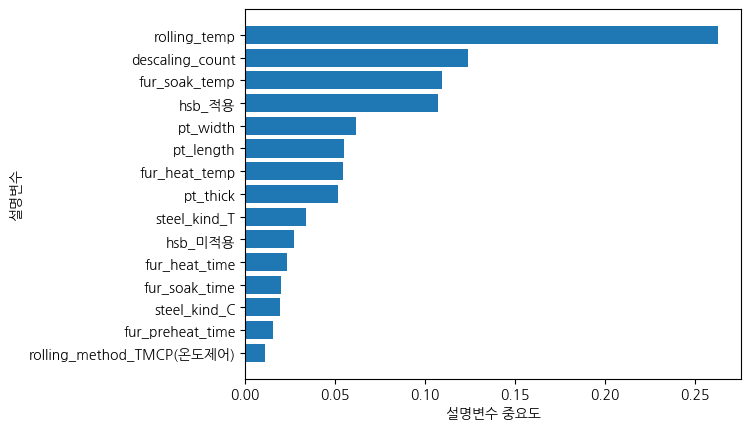

In [33]:
# 설명변수 중요도 그래프
# sort_values : 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))

df_top = df_importance.tail(15)
coordinates = range(len(df_top))
plt.barh(y = coordinates, width = df_top["Importance"])
plt.yticks(coordinates, df_top["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### XGBoost

In [10]:
# XGBClassifier 모델 설정
estimator = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# XGBClassifier에 맞는 하이퍼파라미터 범위 설정
param_grid = {
    "objective": ["binary:logistic"],   # 분류 문제 유형에 맞는 목표 함수
    "max_depth": [int(x) for x in range(1, 31)],                           # 최대 깊이
    "learning_rate": [lr * 0.02 for lr in range(1, 21)],                   # 학습률
    "n_estimators": [int(x) for x in range(50, 501, 50)],                  # 트리 개수
    "min_child_weight": [int(x) for x in range(1, 11)],                    # 자식 노드의 가중치 합 최소값
    "subsample": [0.5, 0.7, 0.8, 1.0],                                     # 각 트리마다 사용할 샘플 비율
    "colsample_bytree": [0.5, 0.7, 0.8, 1.0],                              # 각 트리마다 사용할 특성 비율
    "gamma": [0, 0.1, 0.2, 0.3, 0.4],                                      # 리프 노드에서 추가 분할을 위한 최소 손실 감소 값
}

# RandomizedSearchCV 설정 및 학습
rand_xgb = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    n_iter=500,
    scoring="accuracy",    # 분류 문제에 적합한 평가지표
    n_jobs=-1,
    random_state=1234
)

# 오버샘플링된 학습 데이터 사용
rand_xgb.fit(x_resampled, y_resampled)

# 최적의 결과 출력
print("Best estimator model: \n{}".format(rand_xgb.best_estimator_))
print("\nBest parameter: \n{}".format(rand_xgb.best_params_))
print("\nBest score: \n{}".format(rand_xgb.best_score_.round(3)))


Best estimator model: 
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

Best parameter: 
{'subsample': 1.0, 'objective': 'binary:logistic', 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.7}

Best score: 
0.989


In [9]:
# 모델 생성
rd_xgboost= XGBClassifier(
    subsample=1.0,
    objective='binary:logistic',
    n_estimators=500,
    min_child_weight=1,
    max_depth=5,
    learning_rate=0.3,
    gamma=0, colsample_bytree=0.7, random_state=1234)

# 모델 적합
rd_xgboost.fit(x_resampled, y_resampled)

'''
# 예측 및 모델 평가:Train  
xgb_pred_train = rd_xgboost.predict(x_resampled)

print('\n 모델 평가 : Train \n')
eval_class_model(y_resampled, xgb_pred_train)
print('\n',classification_report(y_resampled, xgb_pred_train))'''


# 예측 및 모델 평가:Test  
xgb_pred_test = rd_xgboost.predict(df_test_x)

print('\n 모델 평가 : Test \n')
eval_class_model(df_test_y, xgb_pred_test)
print('\n',classification_report(df_test_y, xgb_pred_test))
print("Test F1 Score:", f1_score(df_test_y, xgb_pred_test, average="binary"))


 모델 평가 : Test 

오차행렬:
 [[209   2]
 [  3  85]] 

정확도: 0.9833
정밀도: 0.9770
재현율: 0.9659
F1    : 0.9714
AUC   : 0.9782

               precision    recall  f1-score   support

           0       0.99      0.99      0.99       211
           1       0.98      0.97      0.97        88

    accuracy                           0.98       299
   macro avg       0.98      0.98      0.98       299
weighted avg       0.98      0.98      0.98       299

Test F1 Score: 0.9714285714285714


{'pt_thick': 114.0, 'pt_width': 123.0, 'pt_length': 162.0, 'fur_heat_temp': 132.0, 'fur_heat_time': 148.0, 'fur_soak_temp': 157.0, 'fur_soak_time': 99.0, 'rolling_temp': 227.0, 'descaling_count': 267.0, 'fur_preheat_time': 109.0, 'steel_kind_C': 2.0, 'steel_kind_T': 32.0, 'hsb_미적용': 3.0, 'hsb_적용': 19.0, 'rolling_method_TMCP(온도제어)': 2.0, 'furnace_1호기1열': 1.0, 'furnace_1호기2열': 7.0, 'furnace_2호기1열': 1.0, 'furnace_2호기2열': 1.0, 'furnace_3호기1열': 9.0, 'furnace_3호기2열': 7.0}


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

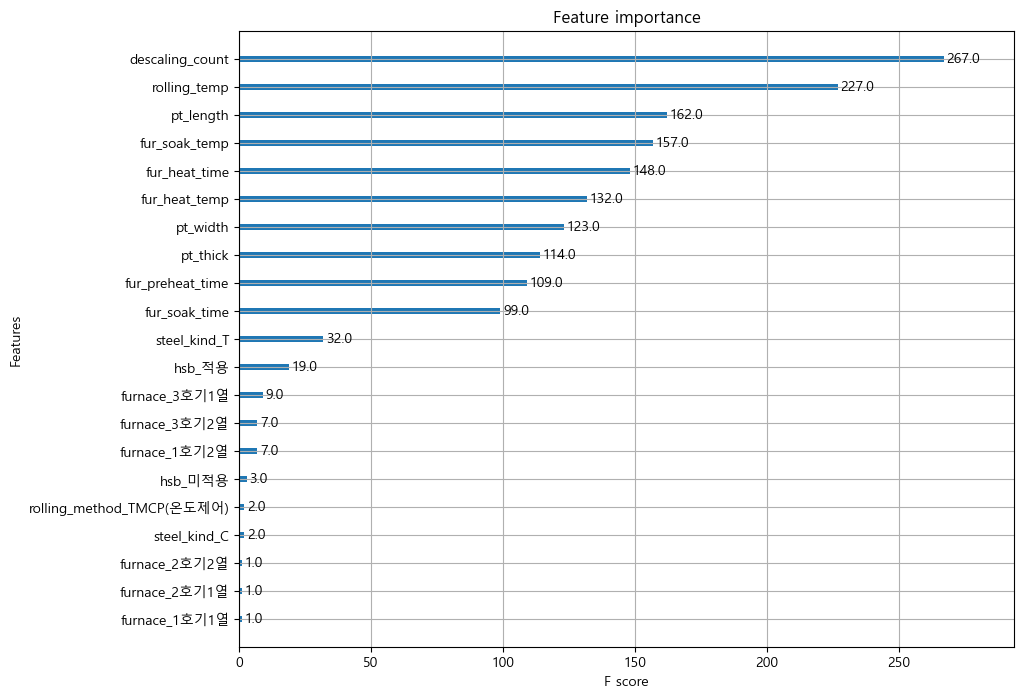

In [11]:
# 변수 중요도 확인 
from xgboost import plot_importance  # F1 score 기준으로 변수 중요도 표시(변경 가능)
print(rd_xgboost.get_booster().get_fscore())

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(rd_xgboost, ax=ax)